<a href="https://colab.research.google.com/github/DhanushAnbalagan/Smart_Sensor_Toilet_Seat_Automation/blob/main/Smart_Toilet_Seat_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ultralytics opencv-python --quiet

import cv2
import numpy as np
from ultralytics import YOLO
from google.colab import files
from google.colab.patches import cv2_imshow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 25.7 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [4]:
video_path = 'toilet_demo.mp4'  # change if different

In [5]:
!ls

sample_data  toilet_demo.mp4


In [6]:
model = YOLO('yolov8n.pt')  # small, fast model

Showing frame 20, persons_detected=False, state=IDLE


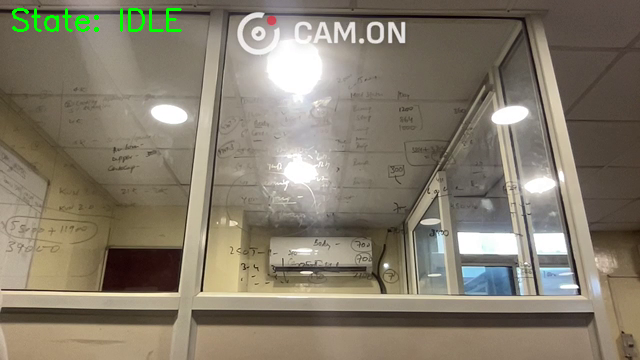

Showing frame 40, persons_detected=False, state=IDLE


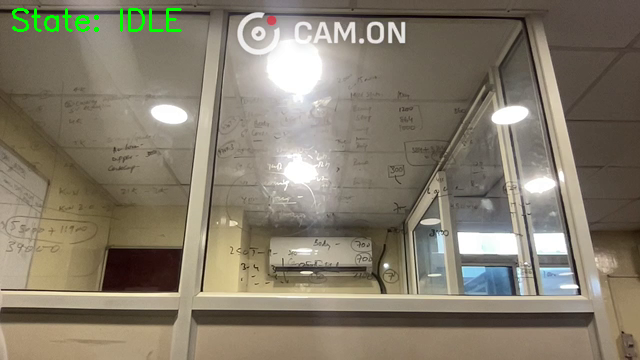

[FRAME 55] OPEN
Showing frame 60, persons_detected=True, state=OPEN


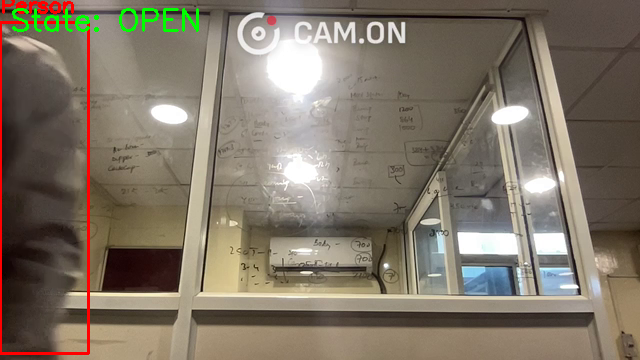

Showing frame 80, persons_detected=True, state=OPEN


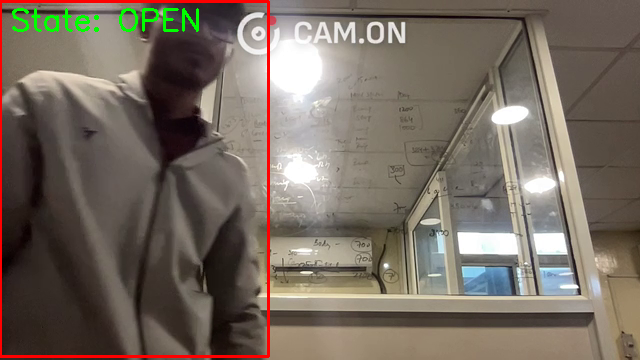

Showing frame 100, persons_detected=True, state=OPEN


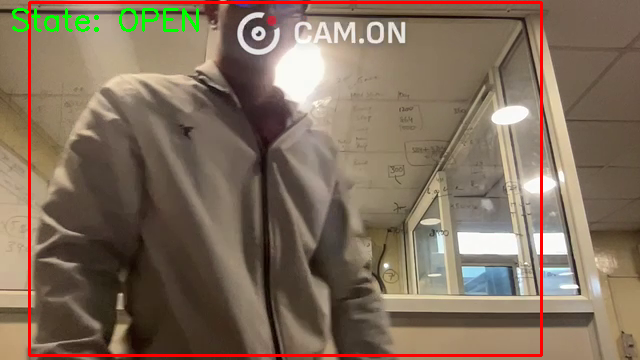

Showing frame 120, persons_detected=True, state=OPEN


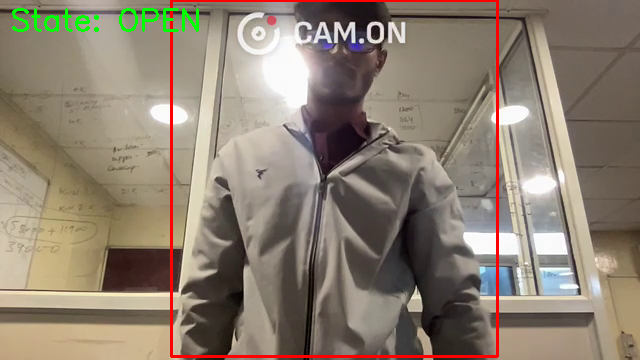

Showing frame 140, persons_detected=True, state=OPEN


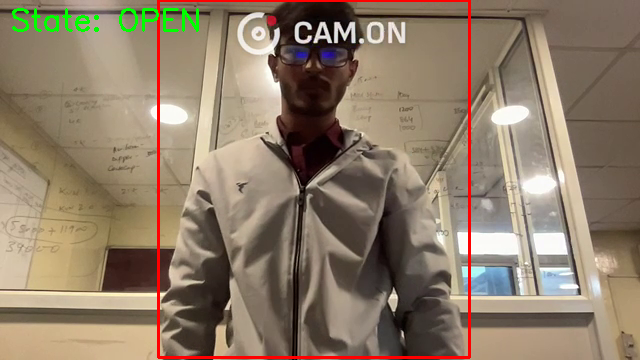

Showing frame 160, persons_detected=True, state=OPEN


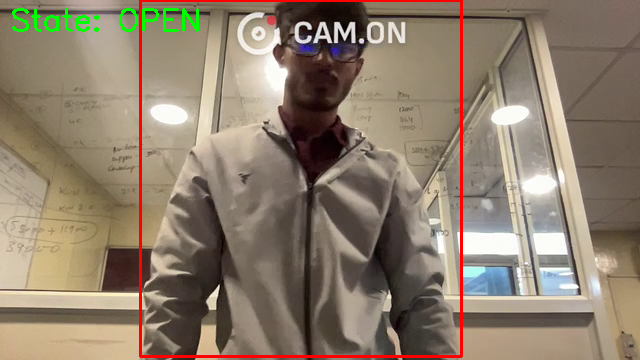

Showing frame 180, persons_detected=True, state=OPEN


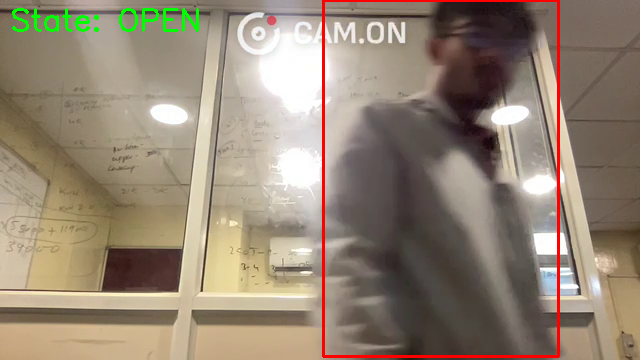

Showing frame 200, persons_detected=True, state=OPEN


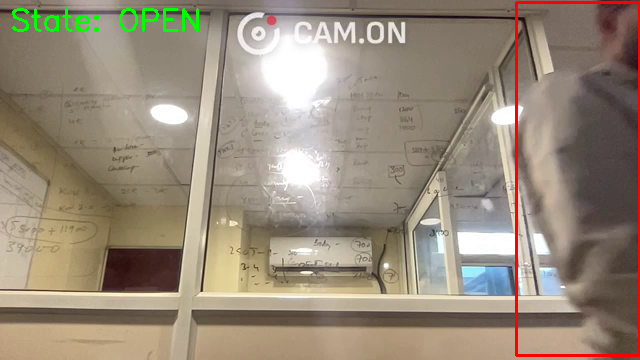

[FRAME 217] FLUSH
Showing frame 220, persons_detected=False, state=FLUSH


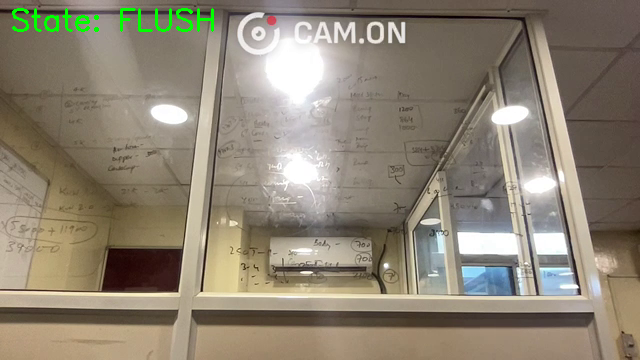

[FRAME 226] BACK TO IDLE
Showing frame 240, persons_detected=False, state=IDLE


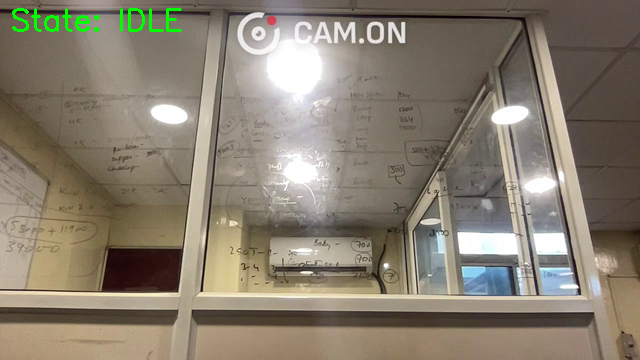

Showing frame 260, persons_detected=False, state=IDLE


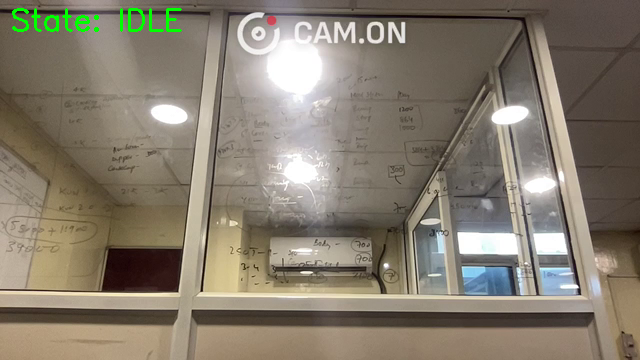

Showing frame 280, persons_detected=False, state=IDLE


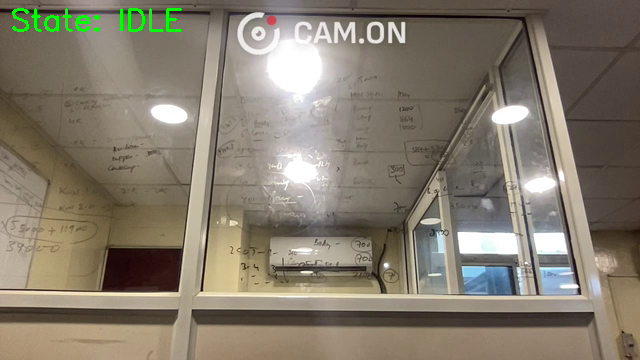

Video finished.


In [11]:
import time
cap = cv2.VideoCapture(video_path)

# ---- STATE VARIABLES ----
state = "IDLE"              # can be: IDLE, OPEN, FLUSH
last_person_time = 0.0
NO_PERSON_TIMEOUT = 2.0     # seconds after last detection before FLUSH
frame_count = 0
opened_once = False         # ensures FLUSH only after OPEN

while True:
    ret, frame = cap.read()
    if not ret:
        print("Video finished.")
        break

    frame_count += 1

    # Resize for speed
    frame = cv2.resize(frame, (640, 360))

    # ----- YOLO PERSON DETECTION -----
    results = model(frame, classes=[0], conf=0.5, verbose=False)  # class 0 = person in COCO

    persons_detected = False
    boxes = []

    if results and len(results) > 0:
        r = results[0]
        if r.boxes is not None and len(r.boxes) > 0:
            persons_detected = True
            for box in r.boxes:
                b = box.xyxy[0].cpu().numpy().astype(int)
                boxes.append(b)

    # Draw bounding boxes
    for (x1, y1, x2, y2) in boxes:
        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 0, 255), 2)
        cv2.putText(frame, "Person", (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

    # ----- STATE MACHINE -----
    current_time = time.time()

    if persons_detected:
        # someone is in front of toilet
        last_person_time = current_time

        if state in ["IDLE", "FLUSH"]:
            state = "OPEN"
            opened_once = True
            print(f"[FRAME {frame_count}] OPEN")

    else:
        # NO person seen in this frame
        # Only flush if we had OPEN before in this cycle
        if opened_once and state == "OPEN":
            if current_time - last_person_time > NO_PERSON_TIMEOUT:
                state = "FLUSH"
                print(f"[FRAME {frame_count}] FLUSH")

        # After FLUSH, return to IDLE after small extra delay
        if state == "FLUSH":
            if current_time - last_person_time > NO_PERSON_TIMEOUT + 2:
                state = "IDLE"
                opened_once = False
                print(f"[FRAME {frame_count}] BACK TO IDLE")

    # Show state on frame
    cv2.putText(frame, f"State: {state}", (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # Show every 20th frame to avoid spamming Colab
    if frame_count % 20 == 0:
        print(f"Showing frame {frame_count}, persons_detected={persons_detected}, state={state}")
        cv2_imshow(frame)

cap.release()
cap = cv2.VideoCapture("/content/toilet_demo.mp4")

state = "IDLE"            # IDLE -> OPEN -> FLUSH -> IDLE
last_person_time = 0
NO_PERSON_TIMEOUT = 2.0   # seconds after last detection to trigger FLUSH
frame_count = 0

has_opened = False        # ensures FLUSH only after OPEN

In [10]:
# --- NEW STATE MACHINE LOGIC ---

current_time = time.time()

if persons_detected:
    last_person_time = current_time

    if state == "IDLE":
        state = "OPEN"
        print(f"[FRAME {frame_count}] OPEN")

    # If person comes back after flush cycle → allow new cycle
    if state == "FLUSH":
        state = "OPEN"
        print(f"[FRAME {frame_count}] OPEN AGAIN")

else:
    # No person detected
    if state == "OPEN":
        # Move to waiting mode (to avoid immediate flush)
        if current_time - last_person_time > NO_PERSON_TIMEOUT:
            state = "WAITING_FOR_FLUSH"

    if state == "WAITING_FOR_FLUSH":
        state = "FLUSH"
        print(f"[FRAME {frame_count}] FLUSH")

    if state == "FLUSH":
        # After flush, reset system back to idle for next cycle
        # Add a delay so flush msg is visible on display/logs
        if current_time - last_person_time > NO_PERSON_TIMEOUT + 2:
            state = "IDLE"
            print(f"[FRAME {frame_count}] BACK TO IDLE")